## Example notebook running SiRCle

In [1]:
from scircm import SciRCM
import pandas as pd

# FORMAT must be csv :) 
data_dir = 'data/'
prot_file = f'{data_dir}prot_DE_Stage IV_sircle.csv'
rna_file = f'{data_dir}rna_DE_Stage IV_sircle.csv'
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'



### Had to run this originally but couldn't upload the data since the file was too big
```
from scircm import filter_methylation_data_by_genes
import numpy as np
meth_df = pd.read_csv(meth_file)
# Note: you need to pass it: 
# 1) the gene ID column, here it is 'ensembl_gene_id'
# 2) the padj column: here it is 'padj_meth'
# 3) the logFC or test statistic column: here it is 'CpG_Beta_diff'
# Since we don't have a beta diff between normal and tumour let's make one (used M values)
meth_df['CpG_Beta_diff'] = np.mean(meth_df[[c for c in meth_df.columns if 'Tumor' in c]].values) - np.mean(meth_df[[c for c in meth_df.columns if 'Normal' in c]].values)
filtered_meth_df = filter_methylation_data_by_genes(meth_df, 'ensembl_gene_id', 'padj_meth', 'CpG_Beta_diff')
# Re point the meth file to be the filtered one
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'
filtered_meth_df.to_csv(meth_file, index=False)
```

## Have a look at each DF to show what is in it

In [2]:
pd.read_csv(prot_file)

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,original_gene_id,...,Protein_Tumor_C3N.01200_CPT0075130003,Protein_Normal_C3N.01220_CPT0076350001,Protein_Tumor_C3N.01220_CPT0076330003,logFC_protein,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein
0,IFITM2,ENSG00000185201,11,303655.0,309397.0,1.0,10581.0,1-8D,IFITM2,IFITM2,...,17.330488,17.219003,17.368543,0.058697,0.759486,4.548756e-01,0.552655,-6.717889,17.336464,0.035891
1,IFITM3,ENSG00000142089,11,319676.0,329475.0,-1.0,10410.0,1-8U,IFITM3,IFITM3,...,21.389833,20.624301,21.268696,0.342514,4.407527,1.833464e-04,0.000666,0.337124,21.053427,0.066014
2,PRDX6,ENSG00000117592,1,173477330.0,173488815.0,1.0,9588.0,1-Cys,PRDX6,PRDX6,...,25.942430,26.157340,26.136880,-0.053029,-0.852348,4.023229e-01,0.501836,-6.642658,26.016635,0.022394
3,ALDH1L1,ENSG00000144908,3,126103562.0,126197994.0,-1.0,10840.0,10-fTHF,ALDH1L1,ALDH1L1,...,24.198385,25.787163,24.507928,-0.894437,-5.830075,5.017052e-06,0.000031,3.902914,24.983542,0.354569
4,KNOP1,ENSG00000103550,16,19701937.0,19718235.0,-1.0,400506.0,101F10.1,KNOP1,KNOP1,...,18.239034,17.378866,17.962233,0.554211,6.769885,5.038201e-07,0.000005,6.194251,17.687298,0.119714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350,ZNF827,ENSG00000151612,4,145757627.0,145938823.0,-1.0,152485.0,NaN,ZNF827,ZNF827,...,16.217080,16.252160,16.008280,-0.096421,-0.706508,4.866184e-01,0.583480,-6.757103,16.415587,0.117283
11351,ZNF865,ENSG00000261221,19,55605647.0,55617269.0,1.0,100507290.0,NaN,ZNF865,ZNF865,...,18.350170,18.384890,18.371440,-0.034837,-0.500347,6.213235e-01,0.704386,-6.883668,18.382762,0.028185
11352,ZNF888,ENSG00000213793,19,52904415.0,52923470.0,-1.0,388559.0,NaN,ZNF888,ZNF888,...,14.805210,14.598660,14.825800,0.148483,5.213043,2.319997e-05,0.000113,2.377486,14.738168,0.007968
11353,ZNRD1,ENSG00000066379,NaN,NaN,NaN,NaN,30834.0,NaN,POLR1H,ZNRD1,...,18.610100,18.353800,18.569210,0.096586,1.143102,2.641749e-01,0.359737,-6.355088,18.508131,0.044773


In [3]:
pd.read_csv(rna_file) # Note we can see that the ensembl gene ID column is named Unnamed: 0 this is 
# From DESeq2 having it as the row name

,Unnamed: 0,external_gene_name,entrezgene_id,hgnc_symbol,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,baseMean_rna,...,RNA_Tumor_C3N.00577_3,RNA_Normal_C3N.01200_1,RNA_Tumor_C3N.01200_1,RNA_Tumor_C3N.01200_2,RNA_Tumor_C3N.01200_3,RNA_Tumor_C3N.01200_4,RNA_Normal_C3N.01220_1,RNA_Tumor_C3N.01220_1,RNA_Tumor_C3N.01220_2,RNA_Tumor_C3N.01220_3
0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,1794.558447,...,5.434883,5.599905,4.629352,4.891962,4.593554,4.837085,5.613410,4.249658,4.867085,5.134165
1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,48.809118,...,0.529242,0.948905,0.229404,0.652659,0.677917,0.291472,1.126509,0.282126,0.610286,0.735218
2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,1236.222835,...,5.223657,4.821487,5.428061,4.756430,4.723433,4.983125,4.658032,5.531724,5.371377,5.379116
3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.007758,-0.104059,9.171225e-01,9.387892e-01,0.074558,1133.146419,...,4.929975,4.745831,4.580305,4.764627,4.647780,4.773554,4.739300,4.750514,4.883110,4.904443
4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,412.698772,...,3.433213,2.969224,3.896414,3.577152,3.593571,3.971502,2.658574,2.988328,3.266873,3.487473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33763,ENSG00000281896,NaN,NaN,NaN,-0.098954,-0.695917,4.864808e-01,5.724860e-01,0.142192,206.580354,...,2.509036,2.618644,2.719000,2.450616,2.643508,2.599286,2.519339,2.802318,2.395787,2.447740
33764,ENSG00000281903,LINC02246,NaN,LINC02246,-0.311020,-1.488246,1.366861e-01,1.974510e-01,0.208984,65.953130,...,0.974198,1.440372,2.024264,1.418020,1.364319,1.548652,1.616073,1.183909,1.448970,1.378556
33765,ENSG00000281910,SNORA50A,677830.0,SNORA50A,0.709131,3.867430,1.099884e-04,3.467546e-04,0.183360,23.625336,...,0.723971,0.398676,0.463802,0.569543,0.584824,0.760479,0.660739,0.634094,0.849903,1.024248
33766,ENSG00000281912,LINC01144,400752.0,LINC01144,-0.638175,-2.901953,3.708440e-03,8.291506e-03,0.219912,36.353359,...,1.011987,0.526789,0.601271,0.787500,0.887335,0.488513,1.154666,1.286824,0.928030,1.204567


In [4]:
rna_df = pd.read_csv(rna_file)
rna_df.rename(columns={'Unnamed: 0': 'ensembl_gene_id'}, inplace=True)
rna_df.to_csv(f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv', index=False)
rna_file = f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv'

In [5]:
pd.read_csv(meth_file)

,Unnamed: 0,Locus,chr,pos,Relation_to_Island,UCSC_RefGene_Group,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,...,CpG_Normal_2ff2d2ea.9b26.487e.be22.e99d42cc2edb_1,CpG_Normal_db23dcfc.0126.49c5.9705.6e1b79fc7df1_1,CpG_Normal_1660d8a3.5f2d.45a4.820a.aa4990b75a8a_1,CpG_Normal_93eeec61.0fa3.43d0.98b5.6d8acd8e69f1_1,CpG_Normal_1a35f502.10c0.4e9b.8274.5494ea50fff5_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
0,cg01473187,cg01473187,chrX,100636165,N_Shore,Body,ENSG00000000003,TSPAN6,TSPAN6,7105,...,0.180325,0.473674,0.290601,0.366690,0.213985,0.299311,0.302644,0.368436,0.190726,-0.035676
1,cg16822540,cg16822540,chrX,100584849,OpenSea,1stExon;5'UTR,ENSG00000000005,TNMD,TNMD,64102,...,0.906177,0.630440,0.860365,0.777538,0.726988,0.818062,0.881122,0.849243,0.916830,-0.035676
2,cg14741366,cg14741366,chr20,50955031,N_Shelf,Body,ENSG00000000419,DPM1,DPM1,8813,...,0.973954,0.907073,0.954293,0.934954,0.901875,0.940070,0.950324,0.944920,0.953963,-0.035676
3,cg08245509,cg08245509,chr1,169894353,S_Shore,TSS1500;TSS1500,ENSG00000000457,SCYL3,SCYL3,57147,...,0.057217,0.105343,0.077352,0.086249,0.135714,0.098847,0.039106,0.044032,0.069995,-0.035676
4,cg06093460,cg06093460,chr1,169733700,OpenSea,5'UTR,ENSG00000000460,C1orf112,C1orf112,55732,...,0.873928,0.832325,0.885978,0.861265,0.786526,0.842439,0.840169,0.899528,0.922147,-0.035676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20842,cg12710480,cg12710480,chr20,33666410,N_Shore,Body;Body;TSS200,ENSG00000288649,ACTL10,ACTL10,170487,...,0.258528,0.233961,0.247719,0.166719,0.239548,0.213720,0.266057,0.216800,0.197770,-0.035676
20843,cg11272349,cg11272349,chr2,233728607,OpenSea,Body;Body;Body;Body;Body;Body;Body;Body;TSS1500,ENSG00000288702,UGT1A3,UGT1A3,54659,...,0.912709,0.922216,0.870761,0.884178,0.925671,0.955566,0.886615,0.858294,0.918659,-0.035676
20844,cg23841280,cg23841280,chr2,233713467,OpenSea,Body;Body;Body;Body;Body;1stExon;Body,ENSG00000288705,UGT1A5,UGT1A5,54579,...,0.863748,0.899406,0.822945,0.843668,0.919372,0.889941,0.846407,0.841862,0.862782,-0.035676
20845,cg08037664,cg08037664,chrX,154885717,N_Shore,Body;TSS1500;TSS1500;Body;TSS1500,ENSG00000288722,F8A1,F8A1,8263,...,0.803331,0.815880,0.728846,0.744514,0.860594,0.820578,0.734450,0.705725,0.800652,-0.035676


## Run SiRCle

In [6]:
# Note we assume your methylation CpGs map to a single gene, if they don't see the section below.
# logFC_rna = column name in your RNA file that has your RNA logFC (same for the protein and CpG)
# padj_rna = column name in your RNA file that has your padj value (same for protein and CpG)
# NOTE: these need to be unique from one another since we merge the datasets, if they aren't, you need
# to update your csv files.
# Lastly: ensembl_gene_id this is the gene ID column, All must use the same identifier, and this must be
# labelled the same in each file, if it isn't, update your column names before running.
rcm = SciRCM(meth_file, rna_file, prot_file, 
             "logFC_rna", "padj_rna", "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein",
             "ensembl_gene_id", sep=',',
             rna_padj_cutoff=0.05, 
             prot_padj_cutoff=0.05, 
             meth_padj_cutoff=0.05,
             rna_logfc_cutoff=1.0, 
             prot_logfc_cutoff=0.5, 
             meth_diff_cutoff=0.1, 
             output_dir='',
             non_coding_genes=['None'],
             output_filename='RCM_Output.csv',
             bg_type = '(P&M)|(P&R)|(M&R)'
         )
rcm.run()
df = rcm.get_df()
# That DF now has your rcm clustering results, how easy was that :D
df # The three columns you now have are: Regulation_Grouping_1, Regulation_Grouping_2, Regulation_Grouping_3

--------------------------------------------------------------------------------
Protein dataset contained duplicates based on ID! Dropping duplicate IDs, note you should do this before running SiRCle. We have just dropped it and kept the first entry. You had: 	14	duplicates.	
--------------------------------------------------------------------------------


,ensembl_gene_id,external_gene_name_r,entrezgene_id_r,hgnc_symbol_r,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,baseMean_rna,...,Protein,RG1_All,RG2_Changes,RG3_Translation,RG4_Detection,Background_filter,RG1_All_filtered,RG2_Changes_filtered,RG3_Translation_filtered,RG4_Detection_filtered
0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,1794.558447,...,Protein DOWN,Methylation No change + RNA No change + Protei...,TMDS,TMDS,TMDS,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,TMDS,TMDS,TMDS
1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,48.809118,...,Protein Undetected,Methylation No change + RNA DOWN + Protein Und...,TPDS_TMDE,TPDS,TPDS,threshold + threshold + NS,Methylation No change + RNA DOWN + Protein Und...,TPDS_TMDE,TPDS,TPDS
2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,1236.222835,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,None,None,None
3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.007758,-0.104059,9.171225e-01,9.387892e-01,0.074558,1133.146419,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,None,None,None
4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,412.698772,...,Protein Undetected,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + NS,Methylation No change + RNA No change + Protei...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38168,ENSG00000235376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38169,ENSG00000213648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38170,ENSG00000124208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein significant-positive,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38171,ENSG00000283900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background


## Plot the clusters

Text(0.5, 1.0, 'Clustered Stage IV patients')

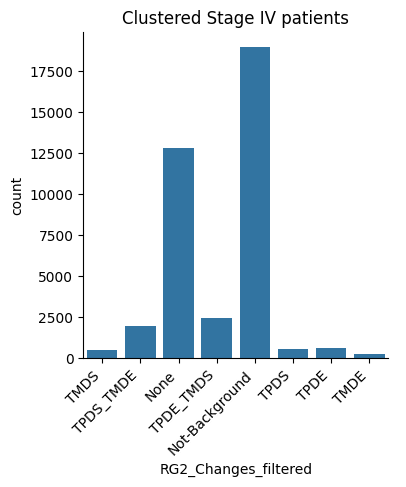

In [7]:
import itertools
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.catplot(data=df, x='RG2_Changes_filtered', kind="count", 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(f'Clustered Stage IV patients')

### Save DF to a file

In [8]:
df.to_csv(f'{data_dir}RCM.csv', index=False)

## Look at enriched TF's

In [9]:
from scimotf import SciMotf_Doro
from scimotf import plot_cluster_tf

rcm_file = f'{data_dir}RCM.csv'
tf_file = f'{data_dir}dorothea_hs_ABCD.csv'
mo = SciMotf_Doro(doro_file=tf_file, cluster_file=rcm_file, 
                  cluster_id='RG2_Changes_filtered',
                  cluster_gene_id='external_gene_name', # got to match motif
                  padj_protein='padj_protein', logfc_protein='logFC_protein', padj_rna='padj_rna',
                  logfc_rna='logFC_rna', output_dir=data_dir)

df = mo.run(['A'], rcm_clusters=["TMDE", "TMDS", "MDS", "MDE", "TPDE", "TPDS"])
df.to_csv(f'{data_dir}scimotif_DORO_A.csv')
plot_cluster_tf(f'{data_dir}scimotif_DORO_A.csv', save_fig=False)

## Train model and compare two groups

### First setup the data

In [10]:
# Load in the files that we used for DE analysis and remove any redundent columns
# the VAE excpets just the ID as the index, and then the values
df = pd.read_csv(f'{data_dir}RCM.csv')

# First filter out any NA values (we're not interested in non SiRCle genes)
rcm_df = df[df['RG2_Changes_filtered'] != 'None']

rna_sample_file = f'{data_dir}rna_sample_data_Stage IV_sircle.csv'
prot_sample_file = f'{data_dir}prot_sample_data_Stage IV_sircle.csv'
# Now we want to merge the clinical info with the cases from the sample df
meth_sample_file = f'{data_dir}cpg_sample_data_Stage IV_sircle.csv'

rna_samples = list(pd.read_csv(rna_sample_file)['FullLabel'].values)
prot_samples = list(pd.read_csv(prot_sample_file)['FullLabel'].values)
meth_samples = list(pd.read_csv(meth_sample_file)['FullLabel'].values)
# Only use the filtered i.e. one CpG to one gene mapping for the cpg data

# ensembl_gene_id that same shared gene ID
cpg_data_df = rcm_df[['ensembl_gene_id'] + meth_samples]
rna_data_df = rcm_df[['ensembl_gene_id'] + rna_samples]
protein_data_df = rcm_df[['ensembl_gene_id'] + prot_samples]


meta_cols = ['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'hgnc_symbol', "logFC_rna", "padj_rna", 
             "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein", "RG2_Changes_filtered"]


# Save to input dir
save_input_data = True
meta_rcm_df = rcm_df[meta_cols].copy()
meta_rcm_df.set_index('ensembl_gene_id', inplace=True)
# Save to the input data dir folder.
if save_input_data:
    protein_data_df.to_csv(f'{data_dir}CPTAC_protein.csv', index=False)
    rna_data_df.to_csv(f'{data_dir}CPTAC_rna.csv', index=False)
    cpg_data_df.to_csv(f'{data_dir}CPTAC_cpg.csv', index=False)
    meta_rcm_df.to_csv(f'{data_dir}RCM.csv')

In [11]:
# Example sample data frame
pd.read_csv(rna_sample_file)

### Next train the model

In [16]:
#from scircm import RCMStats
missing_method='mean'
label = missing_method
sv = RCMStats(rcm_file=f'{data_dir}RCM.csv', 
              patient_sample_file=f'{data_dir}clinical_CPTAC_TCGA.csv', # Clinical file for all patients in the study
              meth_file=f'{data_dir}CPTAC_cpg.csv', 
              meth_sample_file=meth_sample_file, 
              rna_file=f'{data_dir}CPTAC_rna.csv', 
              rna_sample_file=rna_sample_file,
              protein_file=f'{data_dir}CPTAC_protein.csv', 
              protein_sample_file=prot_sample_file,
              output_folder=data_dir, 
              regulatory_label='RG2_Changes_filtered',
              column_id='FullLabel',
              condition_column='CondId',
              patient_id_column='SafeCases', # This is the column that is in each of the sample DFs
              run_name=label,
              normalise='rows', 
              verbose=True,
             missing_method=missing_method)

# Check out the patient info
# Get the patient info that has been compiled from the provided sample files
patient_info = sv.patient_clinical_df
# Select the cases with 5 samples 
matching_patient_info = patient_info[patient_info['Sample counts'] == 5]
matching_cases = matching_patient_info['SafeCases'].values
print("total number of patients: ", len(patient_info), " vs number with matching data: ", len(matching_patient_info))
matching_cases

## Train or re-load saved version

In [15]:
train = True
if train:
    epochs = 100 
    batch_size = 16
    num_nodes = 5
    mmd_weight = 0.25
    loss = {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': mmd_weight}
    config = {"loss": loss,
              "encoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "decoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "latent": {"num_nodes": 1},
              "optimiser": {"params": {'learning_rate': 0.01}, "name": "adam"},
              "epochs": epochs,
              "batch_size": batch_size,
              "scale_data": False
              }
    training_cases = matching_cases # Use matching cases for training
    sv.train_vae(cases=matching_cases, config=config)
    sv.save()  # Save the information we have generated.
else:
    sv.load_saved_vaes()
    sv.load_saved_encodings(f'{sv.output_folder}encoded_df_{label}.csv')
    sv.load_saved_inputs(f'{sv.output_folder}vae_input_df_{label}.csv')
    sv.load_saved_raws(f'{sv.output_folder}raw_input_df_{label}.csv')

## Run the statistics on some different comparisons

This works based on stuff in our sample data frame.

We have a very small dataset (just the stage IV patients) so lets see, maybe just look at gender...

In [ ]:
# Example sample data frame
sv.patient_clinical_df

In [ ]:
from sciutil import SciUtil
u = SciUtil()
u.warn_p(['Gender']) # Got to be the column name in the DF and then two of the conditions in that column
# Note if you get something like: ValueError: `x` and `y` must be of nonzero size. 
# Probably means you didn't have enough patients to do this comparison.
gender_df = sv.run_vae_stats(cond_label='gender', cond0='Female', cond1='Male')

In [ ]:
gender_df

In [ ]:
gender_df[gender_df['Integrated pval (Male-Female)'] < 0.05]

### Interpretation

Note, we can see that when comparing "male" and "female" we get no significant differences (using p.adj).
We have two small groups here (Cond1: 4 vs Cond0: 5) and we're using a mann Whitney U test, which means that the ranks would basically need to be all different to get a significant p-value, and then this gets adjusted out. Things to just be wary of :)

Why you ask do we only have 4 vs 5, it's because some of the patients are missing tumour data, we omit these from the analysis, and the inlcude missing currently is only for the patients with a normal sample missing. If you really want to include those patients, impute the missing tumour data for them (though this would be probably a bad idea).

This was an example using a small dataset (because github limits the file size to 50MB), so try with your own data and if you get stuck please get in contact :) we're happy to help out!

Final caveat that while we're using the column "gender" it may refer to gender or bioloigcal sex, but we're using public data so not actually sure, and also not sure if the form had the full range of genders that exist.
There are lots of genders and hopefully in the future they will be more clear about whether it is gender or biological sex and ensure that in reporting everyone has the ability to specify how they identify if they so choose.